---
title: "Numerical Integration III"
subtitle: ""
format: 
  html:
    toc: true
    code-fold: false
    page-layout: full
    fig-cap-location: bottom
    number-sections: true
    number-depth: 2
    html-to-math: katex
    html-math-method: katex
    callout-appearance: minimal
jupyter: python3
---

# Monte Carlo techniques
_Monte Carlo techniques_ employ random numbers to tackle either naturally stochastic processes or nonprobabilistic problems.In keeping with the theme of the present chapter, we will focus on the latter, namely numerical integration. We start by discussing what "random" numbers are;  we then turn to a detailed discussion of one-dimensional Monte Carlo quadrature, before addressing the real-world problem of multidimensional integration.

##  Random Numbers
Let us consider a nice example of patterns is the decimal digits of the number $\pi$:
$$
\pi = 3.14159265358979323846264338327950\dots
$$
Random simply means that you can not predict the following digit based on the previous digits. In other words, probabbilities for the appearance of any number ($0-9$) in the following digit are equally likely. 

On the other hand, computers produce what are known as _pseudorandom numbers_: the use of the modifier "pseudo" is due to the fact that computers are (supposed to be) deterministic systems. Thus, they produce sequences where each number is completely determined by its predecessor(s). However, if someone who does not have access to the random-number generation algorithm is led to believe that the sequence is truly random, then we have a "good" random-number generator. Thus, when dealing with good pseudorandom number sequences we tend to simply drop the "pseudo" and speak simply of random-number sequences.

## Random Numbers in Python
Python itself includes a high-quality generator in the random module. 

In [5]:
import random
random.seed(314159)
print(random.random())
print(random.random())

0.19236379321481523
0.2868424512347926


We first call the `random.seed()` function to provide the seed (which can be thought as the starting point for a (pseudo-) random number generator). We then see that repeated invocations to the `random.random()` function lead to new random numbers, uniformly distributed in $[0, 1)$ (meaning any numbers in between is equally likely to appear).

If you need several random numbers stored in an array, you could hand-roll a solution using `random.random()`. However, it's probably best to directly employ the functionality contained in `numpy.random.uniform()`: this function takes in three parameters: the first two determine the interval $[a,b)$ while the third one contains the shape of the output array:

In [7]:
import numpy as np
np.random.seed(313159)
print(np.random.uniform(-1,1,4))
print(np.random.uniform(-1,1,(2,3)))

[ 0.5792603  -0.68717081  0.3347907  -0.88203901]
[[-0.60110989  0.48781171  0.91841034]
 [-0.85697526  0.65842403  0.7414521 ]]


## Monte Carlo Quadrature
We now turn to the question of how random numbers can be used to compute integrals, starting from the one-dimensional case for simplicity.

### Probability Summary
#### Discrete Random Variables
Consider a discrete random variable $X$: its possible values are $x_i$, each one appearing with the corresponding probability $p_i^X$. Observe that we are using an upper-case symbol for the random variable and a lower-case symbol for its possible values.

**Mean and variance** The _expectation_ of this random variable (also known as the mean value or expected value) is simply:
$$
\braket{X} = \sum_{i}p_i^X x_i.
$$
One can take the expected value of other quantities, for example the random variable $X^2$. This is called the second moment of $X$ and is simply:
$$
\braket{X^2} = \sum_i p_i^X x_i^2.
$$
This helps us calculate another useful quantity, known as the _variance_, $\mathrm{var}(X)$. The variance is the expectation of the random variable $(X -\braket{X})^2$:
$$
\mathrm{var}(X) = \braket{[ X - \braket{X}]^2}.
$$


A simple calculation leads to an alternative expression for the variance:
$$
\begin{align*}
\mathrm{var}(X) &= \braket{X^2 + \braket{X}^2 - 2X\braket{X}} = \braket{X^2} + \braket{\braket{X}^2} - \braket{2X\braket{X}} \\
& = \braket{X^2} + \braket{X}^2 - 2\braket{X}^2 =\braket{X^2} - \braket{X}^2.
\end{align*}
$$
where we have used the property that 
$$
\braket{aX + b X^2} = a\braket{X} + b \braket{X^2},
$$
namely the $\braket{\cdot}$ operation is linear.

Another concept that is often used is that of the _standard deviation_; this is simply the square root of the variance, $\mathrm{var}(X)$.

If $X$ is a random variable, then $f(X)$ will also be a random variable: taking possible values $f(x_i)$ with probability $p_i^X$.
Thus, it has expectation
$$
\braket{f(X)} = \sum_{i}p_i^X f(x_i)
$$
and, similarly, its variance is:
$$
\begin{align*}
\mathrm{var}[f(X)] &= \braket{[f(X) - \braket{f(X)}]^2} = \braket{f^2(X)} - \braket{f(X)}^2
\end{align*}
$$


####  Continuous Random Variables
For the case of a continuous random variable $X$ we are faced with a _probability density function_, $p(x)$, which plays the role $p_i^X$ played in the discrete case. We typically assume
that the probability density function is normalized, i.e.:
$$
\int_{-\infty}^{\infty} p(x)dx = 1
$$
holds. The definition of the expectation is:
$$
\braket{X} = \int_{-\infty}^{\infty}x p(x) dx.
$$

Similarly, we have for the _variance_:
$$
\begin{align*}
\mathrm{var}(X) &= \braket{[X - \braket{X}]^2} = \int_{-\infty}^{\infty} (x - \braket{X})^2 p(x) dx \\
& = \braket{X^2} - \braket{X}^2
\end{align*}
$$

Similar to the case for discrete random variable, if $X$ is a continuous variable, the $f(X)$ is also a continuous variable. 


### Population Mean and Population Variance
From probability theory, we know that the expectation of a function f of a continuous random variable $X$ is
$$
f(X) = \int_{-\infty}^{\infty}p(x) f(x)dx.
$$

For now, we take $p(x)$, the probability density function, to be uniform from $a$ to $b$, and zero otherwise. This leads to the following result:
$$
\braket{f(X)} = \frac{1}{b-a} \int_{a}^{b} f(x) dx.
$$

Except for the $1/(b-a)$ prefactor, the right-hand side is exactly the numerical integration problem we would like to solve. 

To keep the terminology straight, we will call this $\braket{f(X)}$ the _population mean_. 

Similarly, we introduce the _variance_ of a function of a random variable, in terms of an integral:
$$
\mathrm{var}[f(X)] = \braket{[f(X) - \braket{f(X)}]^2}
$$
and specialize to the case where $p(x) = 1/(b - a)$, to find
$$
\mathrm{var}[f(X)] = \frac{1}{b-a}\int_{a}^b f^2(x)dx 
- \left(\frac{1}{b-a}\int_a^b f(x) dx \right)^2
$$
We call this the _population variance_, and its
square root the _population standard deviation_,$\mathrm{var}[f(X)]$.

Crucially, both the population mean and the population variance, $\braket{f(X)}$ and $\mathrm{var}[f(X)]$, are unknown, i.e., we don't know the value of either $\int_a^b f(x)dx$ or $\int_a^b f^2(x)dx$; this is precisely why we wish to employ Monte Carlo integration. In what follows, we will learn how to estimate both $\braket{f(X)}$ and $\mathrm{var}[f(X)]$.

### Sample Mean and Its Variance
Assume that the random variables $X_0, X_1, X_2, \dots, X_{n-1}$ are drawn randomly from $p(x)$, which for us is uniform from $a$ to $b$. For each of these random variables $X_i$, we act with the function $f$, leading to $n$ new random variables, $f(X_0), f(X_1), f(X_2),\dots, f(X_{n−1})$. 

The _arithmetic average_ of several random variables is also a random variable. We define:
$$
\overline{f} = \frac{1}{n}\sum_{i=0}^{n-1} f(X_i)
$$
which we call the _sample mean_. It is the arithmetic average of the function value over $n$ samples. Crucially, this $\overline{f}$ is a quantity computed from a finite number of samples, $n$; this means it is quite different from the population mean, $\braket{f(X)}$.

We will now see that the sample mean, $\overline{f}$, can be used to estimate the population mean, $\braket{f(X)}$.  Let us examine the expectation of the sample mean
$$
\braket{\overline{f}} = \braket{\frac{1}{n} \sum_{i=0}^{n-1} f(X_i)} = \frac{1}{n}\sum_{i=0}^{n-1}\braket{f(X)} = \braket{f(X)}.
$$

In words, our result is that the _expectation of the sample mean is equal to the population mean_. This motivates our choice to use $\overline{f}$ as an estimator of $f(X)$; for us an estimator is a useful approximation of a given
quantity. It can be shown that as $n\to\infty$, $\overline{f}\to\braket{f(X)}$.

In order to quantify how fast the sample mean approaches the population mean, we turn to the _variance of the sample mean_:
$$
\mathrm{var}(\overline{f}) = \mathrm{var}\left(\frac{1}{n}\sum_{i=0}^{n-1}f(X_i)\right) = \frac{1}{n^2} \sum_{i=0}^{n-1} \mathrm{var}[f(X)] = \frac{1}{n}\mathrm{var}[f(X)],
$${#eq-var-f}
where  we have used the property of variance
$$
\mathrm{var}(\lambda_1 X_1 + \lambda_2 X_2)  = \lambda_1^2 \mathrm{var}(X_1) 
+ \lambda_2^2 \mathrm{var}(X_2).
$$

Thus, our result states that _the variance of the sample mean decreases as $1/n$._ The standard deviation of the sample means goes as $1/\sqrt{n}$, because
$$
\sqrt{\mathrm{var}(\overline{f})} = \frac{1}{\sqrt{n}} \sqrt{\mathrm{var}[f(X)]}.
$$

Notice that on the right hand side the quantity $\mathrm{var}[f(x)]$ is not known, we need to come up with an estimator for $\mathrm{var}[f(X)]$. We propose an estimator
$$
e_{var} = \overline{f^2} - \overline{f}^2 = \frac{1}{n}\sum_{i=0}^{n-1}f^2(X_i) - \left[\frac{1}{n}\sum_{i=0}^{n-1} f(X_i)\right]^2
$$
It is important to note that this expression makes use of the already observed values of $f(X_i)$; this means that it can readily be evaluated.

One can expect its expectation, 
$$
\begin{align*}
\braket{e_{var}}  &= \frac{1}{n}\sum_{i=0}^{n-1} \braket{f^2(X_i)} - \frac{1}{n^2}\sum_{i,j=0}^{n-1}\braket{f(X_i)f(X_j)} \\
&= \frac{1}{n}\sum_{i=0}^{n-1} \braket{f^2(X_i)} - \frac{1}{n^2}\left[\sum_{i=0}^{n-1} \braket{f^2(X_i)} + \sum_{i\neq j}\braket{f(X_i)}\braket{f(X_j)}\right] \\
&=\frac{n-1}{n^2}n\braket{f^2(X)} - \frac{1}{n^2}n(n-1)\braket{f(X)}^2\\
&=\frac{n-1}{n}\left[\braket{f^2(X) - \braket{f(X)}^2}\right] = \frac{n-1}{n}\mathrm{var}[f(X)].
\end{align*}
$$

You see that this estimator $e_{var}$ is close to, but not quite the same as the population variance $\mathrm{var}[f(X)]$.
This implies that it is not an _unbiased estimator_ (i.e., it is a _biased estimator_). . An unbiased estimator $g$ of a quantity $G$ is one for which the mean is equal to the quantity you're trying to estimate, $\braket{g} = G$. But one can trivially define an unbiased estimator $n e_{var}/(n-1)$, since
$$
\braket{\frac{n}{n-1}e_{var}} = \mathrm{var}[f(X)].
$$

With this, we can write @eq-var-f as
$$
\mathrm{var}(\overline{f}) = \frac{1}{n}\mathrm{var}[f(X)] \simeq \frac{1}{n} \frac{n}{n-1} e_{var} = \frac{1}{n-1}(\overline{f^2} - \overline{f}^2).
$$

### Practical Prescription
Let us recall that our goal is to approximate the integral
$$
\int_{a}^b f(x) dx = (b-a)\braket{f(X)}.
$$
Using the estimation described in the previous section, we can write
$$
\begin{align*}
\int_{a}^b f(x) dx &\simeq (b - a)\overline{f} \pm (b-a)\sqrt{\mathrm{var}(\overline{f})} \\
&= (b - a)\overline{f} \pm (b-a)\sqrt{\frac{\overline{f^2} - \overline{f}^2}{n-1}} 
\end{align*}
$$

We took the square root of the variance of the sample mean here to produce the standard deviation of the sample mean; in order to interpret that in the usual (Gaussian) sense of $\pm$, one also needs to make the assumption of a finite variance, which will always be true for us. In other words, we employed the _central limit theorem_ which tells us that asymptotically the $\overline{f}$ obeys a normal/Gaussian distribution regardless of which $p(x)$ was employed to draw the samples (e.g., a uniform one in our case).

We thus have the formula for the _Monte Carlo integration_
$$
\int_a^b f(x) dx \simeq \frac{b - a}{n} \sum_{i=0}^{n-1} f(X_i) \pm \frac{b-a}{\sqrt{n-1}}\sqrt{\frac{1}{n}\sum_{i=0}^{n-1}f^2(X_i) - \left[\frac{1}{n}\sum_{i=0}^{n-1}f(X_i)\right]^2}.
$$

Note that the $\sqrt{n-1}$ i the denominator decreases the standard deviation of the sample mean. The first term $(b-a) f(X_i)$ is similar to the rectangle or midpoint methods.

## Monte Carlo beyond the Uniform Distribution
Having understood how and why Monte Carlo quadrature works, we now see if we can solve harder problems, or solve the same problems better. To give the punchline ahead of time, this will involve non-uniformly distributed random number.

### Generalizing to Weight Functions
In our previous discussion we see that the expectation of a function of a continuous random variable:
$$
\braket{f(X)} = \int_{-\infty}^\infty p(x)f(x) dx.
$$

This time, we take the probability density function to be $w(x)/(b-a)$ from $a$ to $b$ and zero elsewhere. This $w(x)$ is known as the _weight function_, which is positive but general. This leads to 
$$
\braket{f(X)} = \frac{1}{b-a} \int_a^b w(x) f(x) dx. 
$$

Notice that the right hand side is precisely of the form we encounted last week in our discussion of general Gaussian quadrature.
For this new population mean, we can write down the corresponding population variance. 

We could now introduce a new sample mean, 
$$
\overline{f} = \frac{1}{n} \sum_{i=0}^{n-1} f(X_i)
$$
where crucially this time the $X_0, X_1, \dots,  X_{n-1}$ are drawn randomly from the probability density function $p(x) = w(x)/(b-a)$, i.e. _not_ from a uniform distribution.  

We can follow the derivation in the previous section, and obtain the formula for _Monte Carlo integration with a general weight function_:
$$
\int_a^b w(x)f(x) dx \simeq \frac{b - a}{n} \sum_{i=0}^{n-1} f(X_i) \pm \frac{b-a}{\sqrt{n-1}}\sqrt{\frac{1}{n}\sum_{i=0}^{n-1}f^2(X_i) - \left[\frac{1}{n}\sum_{i=0}^{n-1}f(X_i)\right]^2}.
$$
Here the formula looks exactly the same as the previous one, except that $X_i$s are drawn from a different distribution function.

### Inverse Transform Sampling
You may wonder how to draw variables $X_i$s from the probability density function $w(x)/(b-a)$, as you only learned the generation of uniformly distributed random numbers. We now go over a specific technique that helps you accomplish this task, known as _inverse transform sampling_ or, sometimes, simply _inverse sampling_. 

The main idea is to somehow manage to convert the integrand $wf$ to $f$, via an appropriate change of variables. We make the following change of variables
$$
du = w(x)dx,
$$
which can be integrated
$$
u(x) = \int_a^x w(x')dx'.
$$
This $u(x)$ is known as _cumulative distribution function_.

We now realize that when $x$ goes from $a$ to $b$, $u$ goes from $0$ to $b-a$, i.e., $u(a) = 0$ and $u(b) = b-a$.
We thus transform the original integral
$$
\int_{a}^b w(x)f(x)dx = \int_0^{b-a} f(x(u)) du
$$
where $f(x(u))$ means that we've expressed $x$ in terms of $u$. Note that the right hand side is in the form of an _unweighted_ integral over $u$. Thus, we can write
$$
\int_a^b w(x)f(x) dx = \int_0^{b-a}f(x(u))du  \simeq  \frac{b-a}{n} \sum_{i=0}^{n-1} f(X(U_i)).
$$

To reiterate, the $U_i$s are uniformly distributed from $0$ to $b-a$ and as a result the $X_i$s (which are produced by $x(u)$ which is inverted from $u(x)$) are distributed according to $w(x)$ from $a$ to $b$. In summary, we've managed to employ uniform numbers, together with a transformation, to apply Monte Carlo to a weighted integral.

Let us look at a specific example:
$$
I = \int_0^1 e^{-x} \cos(x) dx.
$$

You can definitely choose $f(x) = e^{-x}\cos(x)$ and sample $x$ uniformly in the interval between $0$ and $1$. However, since $e^{-x}$ makes the integrand $f(x)$ decrease as $x$ is increasing, you are not taking into the consideration the fact the most of the contribution to the integral comes from small values of $x$.

Instead, we can take the weight function $w(x) = ce^{−x}$, where we normalize the weight function by choosing $c = e/(e-1)$, namely
$$
\int_0^1 w(x)dx = \int_0^1 \frac{1}{e-1} e^{-x}dx = 1.
$$
We then choose the function $f(x) = \cos(x)/c$, such that the normalization constant get canceled.

The inverse transform method then tells you to evaluate $u(x)$ as
$$
u(x) = c\int_0^x e^{-x'} dx' = c(1-e^{-x})
$$
which leads to 
$$
x(u) = -\ln\left( 1 - \frac{u}{c}\right).
$$

Thus, we can write 
$$
\begin{align*}
I &= \int_0^1 c e^{-x} \frac{\cos x}{c} dx = \int_0^1 \frac{1}{c} \cos\left[-\ln \left( 1 - \frac{u}{c}\right) \right]du \\
& \simeq \frac{1}{n} \sum_{i=0}^{n-1} \frac{1}{c}  \cos\left[-\ln \left( 1 - \frac{U_i}{c}\right) \right].
\end{align*}
$$
where $U_i$s are sampled uniformly from $0$ to $1$. 

You see that you have managed to sample from an exponential distribution, even though your input random-number generator was for a uniform distribution.

### Importance Sampling
In this section, we will show that we can even introduce weight functions by hand even the integrand appears to be a single (i.e. unweighted) function:
$$
\int_a^b f(x) dx = \int_a^b w(x) \frac{f(x)}{w(x)} dx = \int_0^{b-a} \frac{f(x(u))}{w(x(u))}du \simeq \frac{b-a}{n}\sum_{i=0}^{n-1} \frac{f(X(U_i))}{w(X(U_i))}.
$$

- In the first equality we multiplied and divided with a positive weight function of our choosing. 
- In the second equality we used the change of variables as we did previously.
- In the thrid equality we treated $f/w$ as our ("unweighted") integrand and therefore used $U_i$s which are uniformly distributed from $0$ to $b-a$. 

The entire process is known as _importance sampling_.

You may be wondering why we went through the trouble of doing this. The answer is as follows: if you choose a $w(x)$ that behaves approximately the same way that $f(x)$ does,then your random numbers will be distributed in the most "important" regions, instead of uniformly. To put the same idea differently: since our (unweighted) integrand is $f/w$, the variance will be computed with $f/w$ in the place of $f$. Since $w(x)$ is chosen to be similar to $f(x)$, we see that $f/w$ will be less varying than f itself was; this will lead to a reduction of the variance, i.e., a better overall estimate of the integral we are trying to compute.

To see this in action, we turn to the example we've been revisiting throughout numerical integration, namely we integrate the following function
$$
f(x) = \frac{1}{\sqrt{x^2 + 1}}
$$
from 0 to 1. We can plot it in the following (blue solid curve).

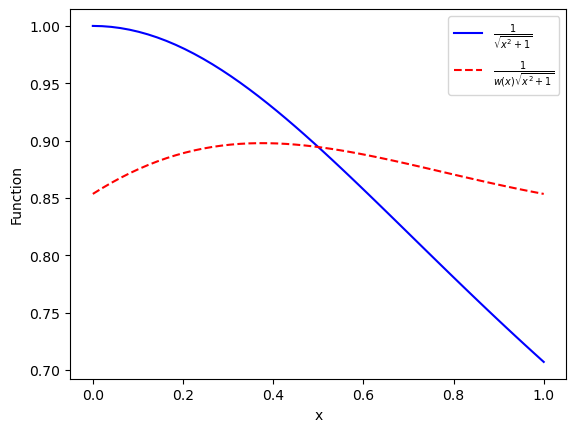

In [8]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0,1,50)
fx = 1/np.sqrt(x**2+1)
c0 = 4-2*np.sqrt(2)
c1 = -6+4*np.sqrt(2)
wx = c0 + c1*x
plt.plot(x, fx,'b-', label=r'$\frac{1}{\sqrt{x^2 + 1}}$')
plt.plot(x, fx/wx,'r--', label=r'$\frac{1}{w(x)\sqrt{x^2 + 1}}$')
plt.xlabel('x')
plt.ylabel('Function')
plt.legend()
plt.show()

We see that $f(x)$ is decreasing from 1 to 0.7 in our interval; with that in mind, we decide to employ a linear weight function:
$$
w(x) = c_0 + c_1 x.
$$
We wish $w(x)$ to roughly track the behavior of $f(x)$ in our interval; one way to do this is to ensure that $f(0)/w(0) = f(1)/w(1)$.
This gives one equation relating $c_0$ and $c_1$. If we then also impose the normalization condition
$$
\int_0^1 w(x)dx = 1
$$
we get another relation. Thus, we are able to determine both parameters:
$$
c_0 = 4 - 2\sqrt{2}, \quad c_1 = -6 + 4\sqrt{2}. 
$$

In the above figure, the red dashed line corresponds to the value of $f(x)/w(x)$, which varies between 0.85 and 0.9, which is considerably smaller than the variation of our original integrand.

Now, we apply the importance-sampling prescription. We first compute
$$
u(x) = \int_{0}^x (c_0 + c_1x') dx' = c_0 x + \frac{1}{2}c_1x^2,
$$
which can be inverted to obtain
$$
x(u) = \frac{-c_0 + \sqrt{2c_1 u + c_0^2}}{c_1}.
$$

Note that we picked the root which leads to $x$ from 0 to 1 for $u$ in $[0,1]$. We can now compute the integral as
$$
\int_0^1 \frac{1}{\sqrt{x^2+1}}dx  \simeq \frac{1}{n} \sum_{i=0}^{n-1} \frac{1}{\sqrt{X(U_i)^2 + 1}(c_0 + c_1 X(U_i))}
$$
in which $U_i$ are uniformly distributed. 

### Implementation
We now implement Monte Carlo quadrature for the case of a one-dimensional integral. This is done in `montecarlo()`, which addresses both the case of uniform sampling and that of importance sampling. Crucially, uniform sampling is the default parameter value, which means that you can call this function with `montecarlo(f,a,b,n)`, i.e., with precisely the same interface as our three integrators in the Newton-Cotes integration and Gauss-Legendre integration. 

Also, we wrote a different function `stats(fs)`, which compute the mean and standard deviation for a given array. 

In [1]:
import numpy as np

def f(x):
    return 1/np.sqrt(x**2 + 1)
    
def montecarlo(f,a,b,n,option="uniform"):
    np.random.seed(314159)
    us = np.random.uniform(a, b, n)

    if option=="uniform":
        fs = f(us)
    else:
        c0 = 4 - 2*np.sqrt(2)
        c1 = -6 + 4*np.sqrt(2)
        xs = (-c0 + np.sqrt(2*c1*us + c0**2))/c1
        fs = f(xs)/(c0 + c1*xs)

    fbar, err = stats(fs)
    return (b-a)*fbar, (b-a)*err

def stats(fs):
    n = fs.size
    fbar = np.sum(fs)/n
    fsq = np.sum(fs**2)/n
    varfbar = (fsq - fbar**2)/(n - 1)
    return fbar, np.sqrt(varfbar)

if __name__ == '__main__':
    for n in 10**np.arange(2,7):
        avu, erru = montecarlo(f, 0., 1., n)
        avi, erri = montecarlo(f, 0., 1., n, option="is")
        rowf = "{0:7d}   {1:1.9f} {2:1.9f}   {3:1.9f} {4:1.9f}"
        print(rowf.format(n, avu, erru, avi, erri))

    100   0.873135430 0.009827018   0.880184046 0.001397861
   1000   0.878313494 0.003014040   0.880653976 0.000439206
  10000   0.879343920 0.000933506   0.881029489 0.000139055
 100000   0.881289768 0.000292906   0.881400087 0.000043577
1000000   0.881433836 0.000092589   0.881389786 0.000013775


We see that importance sampling consistently helps us reduce the standard deviation by an order of magnitude.

## Monte Carlo in Many Dimensions
We now turn to a truly relevant application of the Monte Carlo approach: multidimensional integration. As in the one-dimensional case, we start from uniform sampling, but then try to do a better job: we explain how to carry out weighted sampling via the _Metropolis-Hastings_ algorithm, which is one of the most successful methods ever.

### Uniform Sampling
Notations: we bundle together the variables $x_0, x_1, \dots, x_{d-1}$ into $\boldsymbol{x}$. We will be dealing with a scalar function of many variables, $f(\boldsymbol{x})$. We define the _population mean_
$$
\braket{f(\boldsymbol{X})} = \frac{1}{V}\int f(\boldsymbol{x}) d^dx
$$
where the left hand side is of a function of a multidimensional random variable $\boldsymbol{X}$. The volume $V$ is the generalization of the interval length $b-a$.

The practical formula for _multidimensional Monte Carlo integration_ is
$$
\int f(\boldsymbol{x})d^d x \simeq \frac{V}{\mathcal{N}}\sum_{i=0}^{\mathcal{N} - 1} f(\boldsymbol{X}_i) \pm 
\frac{V}{\mathcal{N} - 1} \sqrt{\frac{1}{\mathcal{N}}\sum_{i=0}^{\mathcal{N}-1}f^{2}(\boldsymbol{X}_i) - \left[\frac{1}{\mathcal{N}} \sum_{i=0}^{\mathcal{N}-1}
f(\boldsymbol{X}_i)\right]^2} 
$$
where $\mathcal{N}$ is the number of samples, and $\boldsymbol{X}_i$ are sampled uniformly.

### Weighted Sampling via the Metropolis–Hastings Algorithm
We can also introduce a weight for the multidimensional problem, and obtain
$$
\int w(\boldsymbol{x}) f(\boldsymbol{x})d^d x \simeq \frac{V}{\mathcal{N}}\sum_{i=0}^{\mathcal{N} - 1} f(\boldsymbol{X}_i) \pm 
\frac{V}{\mathcal{N} - 1} \sqrt{\frac{1}{\mathcal{N}}\sum_{i=0}^{\mathcal{N}-1}f^{2}(\boldsymbol{X}_i) - \left[\frac{1}{\mathcal{N}} \sum_{i=0}^{\mathcal{N}-1}
f(\boldsymbol{X}_i)\right]^2} 
$$
where $\boldsymbol{X}_i$ are drawn from the distribution $w(\boldsymbol{x})$.

We can in principle derive formulas for inverse sampling, however, the multidimensional case would be much more complicated and practically this is very difficult to perform. In the following, we will construct a way to sample $\boldsymbol{X}_i$ directly from distribution $w(\boldsymbol{x})$.

#### Markov Chains
We shall introduce the so-called _Markov chain Monte Carlo (MCMC)_. The main new concept involved here is that of a _Markov chain_: imagine you have a sequence of random samples $\boldsymbol{X}_0,\boldsymbol{X}_1,\dots,\boldsymbol{X}_{\mathcal{N}-1}$ for which a given sample $\boldsymbol{X}_i$ depends only on the previous one $\boldsymbol{X}_{i-1}$, but not on any of the earlier ones. In other words, one starts from a random sample $\boldsymbol{X}_0$, uses that to produce sample $\boldsymbol{X}_1$, then uses that in its turn to produce sample $\boldsymbol{X}_2$, and so on. This sequence of samples $\boldsymbol{X}_0,\boldsymbol{X}_1,\dots,\boldsymbol{X}_{\mathcal{N}-1}$ is known as a _random walk_. 

Note that this is quite different from what we were doing in earlier sections: there the $X_i$ were independent from one another, whereas now we use a given $\boldsymbol{X}_{i-1}$ to produce the next one $\boldsymbol{X}_{i}$. The reason Markov chains are so useful is that they can be produced such that they asymptotically (i.e., as $\mathcal{N}\to \infty$) have the distribution we would like them to, which in our case would be $w(\boldsymbol{x})$. One could therefore do an increasingly better job at computing a $d$-dimensional integral by continuing the Markov chain for larger values of $\mathcal{N}$.

#### Detailed Balance
We wish to produce a Markov chain with an asymptotic distribution of our choosing, which would therefore be the stationary distribution of the chain. Thus, we can borrow ideas from the statistical mechanics of systems in equilibrium. A sufficient (but not necessary) condition of evolving toward equilibrium and staying there is the _principle of detailed balance_:
$$
w(\boldsymbol{X}) T(\boldsymbol{X} \to \boldsymbol{Y}) = w(\boldsymbol{Y}) T(\boldsymbol{Y} \to \boldsymbol{X}).
$$
Here $T(\boldsymbol{X}\to \boldsymbol{Y})$ is the (conditional) probability density that you will move to $\boldsymbol{Y}$ if you start at $\boldsymbol{X}$; it is often called the _transition probability_. 

Since we're dealing with a Markov chain, we need to know how to go from one sample to the next; this is precisely what the transition probability will allow us to do. Since $w(\boldsymbol{X})$ is the probability density of being near $\boldsymbol{X}$, $w(\boldsymbol{X})T(\boldsymbol{X}\to\boldsymbol{Y})$ quantifies how likely it is to start at $\boldsymbol{X}$ and move to $\boldsymbol{Y}$. Similarly, $W(\boldsymbol{Y})T(\boldsymbol{Y}\to\boldsymbol{X})$ tells us how likely it is to start at $\boldsymbol{Y}$ and move to $\boldsymbol{X}$. 

In words, the principle of detailed balence says that it is equally likely that we will go in one direction as in the reverse direction. The principle of detailed balance is sometimes known as the reversibility condition, due to the fact that the reverse process would result if everything went backward in time. Intuitively, detailed balance tells us that if you're in equilibrium then effectively not much is changing: you could go somewhere, but you're just as likely to come back.

At this stage, detailed balance is just a condition: we haven't shown how to actually produce a Markov chain that obeys it. Even so, we will now spend some time seeing exactly
how the detailed-balance condition can help us accomplish our goal. Instead of thinking about moving from an individual sample to another one, it can be helpful to think in terms of going from one probability density function to another. 

Assume that $p_{i-1}(\boldsymbol{X})$ is the distribution of values of the random variable $\boldsymbol{X}_{i-1}$ and, similarly, $p_i(\boldsymbol{X})$ is the distribution of $\boldsymbol{X}_i$. We can straightforwardly relate $p_i(\boldsymbol{X})$ to $p_{i-1}(\boldsymbol{X})$ as follows:
$$
p_i(\boldsymbol{X}) = p_{i-1}(\boldsymbol{X}) + \int [p_{i-1}(\boldsymbol{Y})T(\boldsymbol{Y}\to \boldsymbol{X}) - p_{i-1}(\boldsymbol{X})T(\boldsymbol{X}\to\boldsymbol{Y})]d^d Y.
$$
In words, what this is saying is that the probability of being near $\boldsymbol{X}$ at step $i$ is equal to the probability of being near $\boldsymbol{X}$ at step $i-1$, plus the probability of leaving all other configurations $\boldsymbol{Y}$ and coming to $\boldsymbol{X}$, minus the probability of leaving $\boldsymbol{X}$ and going to any other configurations $\boldsymbol{Y}$. 

We can first show that $w(\boldsymbol{X})$ is a fixed point of the iteration: for $p_{i-1}(\boldsymbol{X})=w(\boldsymbol{X})$, we have
$$
p_i(\boldsymbol{X})  = w(\boldsymbol{X}) + \int [w(\boldsymbol{Y})T(\boldsymbol{Y}\to\boldsymbol{X}) - w(\boldsymbol{X})T(\boldsymbol{X}\to\boldsymbol{Y})]d^d Y = w(\boldsymbol{X}),
$$
where in the last step we have used th detailed-balence condition. 

Second, we would like to know that we are actually approaching that stationary distribution: it wouldn't do us much good if a fixed point existed but we could never reach it. To see this, we can write
$$
\frac{p_i(\boldsymbol{X})}{w(\boldsymbol{X})} = \frac{p_{i-1}(\boldsymbol{X})}{w(\boldsymbol{X})} + \int [p_{i-1}(\boldsymbol{Y})\frac{T(\boldsymbol{Y}\to \boldsymbol{X})}{w(\boldsymbol{X})} - p_{i-1}(\boldsymbol{X})\frac{T(\boldsymbol{X}\to\boldsymbol{Y})}{w(\boldsymbol{X})}]d^d Y.
$$
Using the detailed-balence condition in this form:
$$
\frac{T(\boldsymbol{X} \to \boldsymbol{Y})}{w(\boldsymbol{Y})}  = \frac{T(\boldsymbol{Y}\to\boldsymbol{X})}{w(\boldsymbol{X})},
$$
we have
$$
\frac{p_i(\boldsymbol{X})}{w(\boldsymbol{X})} = \frac{p_{i-1}(\boldsymbol{X})}{w(\boldsymbol{X})} + \int T(\boldsymbol{X}\to \boldsymbol{Y})\left[\frac{p_{i-1}(\boldsymbol{Y})}{w(\boldsymbol{Y})} - \frac{p_{i-1}(\boldsymbol{X})}{w(\boldsymbol{X})}\right]d^d Y.
$$

Note that here $T(\boldsymbol{X}\to \boldsymbol{Y})$ is the transition probability and thus is positive. To understand the above expression:

- Let's say a $\frac{p_{i-1}(\boldsymbol{X})}{w(\boldsymbol{X})}$ is near a maximum, i.e., is larger than other ratios, $\frac{p_{i-1}(\boldsymbol{Y})}{w(\boldsymbol{Y})}$. Then, the integral will become nagative and thus $\frac{p_{i}(\boldsymbol{X})}{w(\boldsymbol{X})}$ will become smaller. 
- Let's say a $\frac{p_{i-1}(\boldsymbol{X})}{w(\boldsymbol{X})}$ is near a minimum, i.e., is smaller than other ratios, $\frac{p_{i-1}(\boldsymbol{Y})}{w(\boldsymbol{Y})}$. Then, the integral will become positive and thus $\frac{p_{i}(\boldsymbol{X})}{w(\boldsymbol{X})}$ will become larger. 

In both cases, the ratio  $\frac{p_{i}(\boldsymbol{X})}{w(\boldsymbol{X})}$ will be closer to 1 than $\frac{p_{i-1}(\boldsymbol{X})}{w(\boldsymbol{X})}$ was.

While we still haven't shown how to produce a Markov chain that obeys detailed balance, our two results are that if you have a Markov chain that obeys detailed balance then:

a. $w(\boldsymbol{X})$ is a _stationary distribution_, 
b. $p_i(\boldsymbol{X})$ _asymptotically approaches that stationary distribution_. 

In other words, our Markov chain will approach a $d$-dimensional equilibrium distribution of our choosing. We will now introduce an elegant trick that is able to produce a Markov chain obeying detailed balance.

#### Metropolis–Hastings Algorithm
The _Metropolis–Hastings algorithm_ starts by splitting the transition probability:
$$
T(\boldsymbol{X}\to\boldsymbol{Y}) = \pi(\boldsymbol{X}\to\boldsymbol{Y})\alpha(\boldsymbol{X}\to\boldsymbol{Y})
$$
where $\pi(\boldsymbol{X}\to\boldsymbol{Y})$ is the probability of making a _proposed_ step from $\boldsymbol{X}$ to $\boldsymbol{Y}$ and $\alpha(\boldsymbol{X}\to\boldsymbol{Y})$ is the probability of _accepting_ that move.

Note that since we are dealing with an _acceptance_ probability $\alpha(\boldsymbol{X}\to\boldsymbol{Y})$, this means that some moves will be accepted (i.e., the system moves from $\boldsymbol{X}$ to $\boldsymbol{Y}$) and some moves will be rejected (i.e., the system will stay at $\boldsymbol{X}$). The proposal probability $\pi(\boldsymbol{X}\to\boldsymbol{Y})$ is not unique, and several choices are discussed in the literature. The acceptance probability will be chosen in such a way that detailed balance is obeyed. 

The Metropolis–Hastings algorithm proceeds by evaluating the following quantity
$$
R(\boldsymbol{X}\to\boldsymbol{Y}) = \frac{w(\boldsymbol{Y})\pi(\boldsymbol{Y}\to\boldsymbol{X})}{w(\boldsymbol{X})\pi(\boldsymbol{X}\to\boldsymbol{Y})}
$$
known as the _Metropolis-Hasting ratio_. 
Here everything on the right-hand side is known: the desired distribution $w$ is of our choosing, as is also true of the proposal distribution $\pi$. As a matter of fact, a simpler version of the Metropolis-Hastings algorithm, known as the _Metropolis algorithm_ since that's how it was originally put forward, employs a symmetric proposal distribution; when $\pi(\boldsymbol{X}\to\boldsymbol{Y})=\pi(\boldsymbol{Y}\to\boldsymbol{X})$ you can see that the ratio is simply $R(\boldsymbol{X}\to\boldsymbol{Y}) = w(\boldsymbol{Y})/w(\boldsymbol{X})$, namely the ratio of the (analytical known) desired weight at the configuration $\boldsymbol{Y}$ and at the configuration $\boldsymbol{X}$.

The next part of the Metropolis-Hastings algorithm is to use the ratio $R(\boldsymbol{X}\to\boldsymbol{Y})$ to determine the acceptance probability as follows:
$$
\alpha(\boldsymbol{X}\to\boldsymbol{Y}) = \min[1, R(\boldsymbol{X}\to\boldsymbol{Y})].
$$

We already know that $R(\boldsymbol{X}\to\boldsymbol{Y})$ is non-negative. What the above equation does is to account for the possibility that the ratio $R(\boldsymbol{X}\to\boldsymbol{Y})$ is larger than 1: in that case, the acceptance probability is taken to be 1. If $R$ is less than 1, then the proposed step is taken with probability $R$.

We can show that with this choice of $\alpha(\boldsymbol{X}\to\boldsymbol{Y})$, detailed balance is satisfied. 
Let us first assume $R(\boldsymbol{X}\to\boldsymbol{Y})<1$, then 
$$
\begin{align*}
w(\boldsymbol{X})T(\boldsymbol{X}\to\boldsymbol{Y}) &= w(\boldsymbol{X})\pi(\boldsymbol{X}\to\boldsymbol{Y})R(\boldsymbol{X}\to\boldsymbol{Y})
= w(\boldsymbol{X})\pi(\boldsymbol{X}\to\boldsymbol{Y})\frac{w(\boldsymbol{Y})\pi(\boldsymbol{Y}\to\boldsymbol{X})}{w(\boldsymbol{X})\pi(\boldsymbol{X}\to\boldsymbol{Y})} \\
&=w(\boldsymbol{Y})\pi(\boldsymbol{Y}\to\boldsymbol{X})
\end{align*}
$$
Since $R(\boldsymbol{X}\to\boldsymbol{Y})R(\boldsymbol{Y}\to\boldsymbol{X})=1$, we have $R(\boldsymbol{Y}\to\boldsymbol{X})>1$ if $R(\boldsymbol{X}\to\boldsymbol{Y})<1$. 
Thus, we have $\alpha(\boldsymbol{Y}\to\boldsymbol{X}) = 1$. We can thus write
$$
w(\boldsymbol{X})T(\boldsymbol{X}\to\boldsymbol{Y}) = w(\boldsymbol{Y})\pi(\boldsymbol{Y}\to\boldsymbol{X})\alpha(\boldsymbol{Y}\to\boldsymbol{X}) = w(\boldsymbol{Y})T(\boldsymbol{Y}\to\boldsymbol{X}).
$$
This proves the detailed balance condition when $R(\boldsymbol{X}\to\boldsymbol{Y})<1$. In your homework, you will show the detailed balance condition if $R(\boldsymbol{X}\to\boldsymbol{Y})> 1$.

In summary, we have shown that _the Metropolis–Hastings algorithm_ satisfies detailed balance.  As we discussed, detailed balance means that $w(\boldsymbol{X})$ is a stationary distribution and our random walk will be asymptotically approaching that stationary distribution. Thus, we have managed to draw random samples from a $d$-dimensional distribution, which was our goal all along.

It is important to emphasize that the Metropolis–Hastings algorithm has allowed us to draw random samples from a $d$-dimensional $w(\boldsymbol{X})$ simply by calculating ratios of $w$ (and perhaps also of $\pi$) at two configurations each time. There was no need to worry about a change of variables, no numerical multidimensional inversion, and so on. Simply by evaluating known quantities at a given and a trial configuration, we managed to solve a complicated sampling problem. This is why the Metropolis–Hastings prescription is routinely listed among the most important algorithms of the twentieth century.



#### How to Implement the Metropolis Algorithm
We now give a practical step-by-step summary of the Metropolis algorithm, which allows us to sample from the $d$-dimensional distribution $w(\boldsymbol{X})$.

1. Start at a random location, $\boldsymbol{X}_0$. It shouldn't matter where you start, since the Markov chain will "equilibrate", reaching the same stationary distribution, anyway. You could account for this "burn-in" time by discarding some early iterations or you could start from an $\boldsymbol{X}_0$ that is not highly unlikely, i.e., pick X0 such that $w(\boldsymbol{X}_0)$ is not too small.
2. Take $\boldsymbol{X}_{i−1}$ as given (this is $\boldsymbol{X}_{0}$ the first time around) and produce a uniformly distributed proposed step according to: 
   $$
   \boldsymbol{Y}_i = \boldsymbol{X}_{i-1} + \theta \times \boldsymbol{U}_i
   $$
   where $\boldsymbol{U}_i$ is a $d$-dimensional sample of uniformly distributed random numbers from $-1$ to $1$; here $\theta$ is a number that controls the "step size" and $\boldsymbol{Y}_i$ is the proposed walker configuration. This step, being uniformly distributed in a multidimensional cube of side $2\theta$, is in fact employing a proposal distribution $\pi$ that is symmetric; this means that we are actually dealing with the simple Metropolis algorithm. The value of $\theta$ is chosen (by trying) such that roughly $15\%$ to $50\%$ of the proposed steps are accepted.
3. For Metropolis algorithm, we can compute the acceptance rate
   $$
   \alpha(\boldsymbol{X}_{i-1}\to\boldsymbol{Y}_i) = \min\left[1,\frac{w(\boldsymbol{Y}_i)}{w(\boldsymbol{X}_{i-1})}\right].
   $$
   Here you see only the ratio $\frac{w(\boldsymbol{Y}_i)}{w(\boldsymbol{X}_{i-1})}$ matters and thus we do not need to normalize $w(\boldsymbol{X})$.
4. With probability $\alpha(\boldsymbol{X}_{i-1}\to\boldsymbol{Y}_i)$, set $\boldsymbol{X}_i=\boldsymbol{Y}_i$ (the proposed step is accepted), otherwise set $\boldsymbol{X}_i=\boldsymbol{X}_{i-1}$ (the proposed step is rejected). In practice, this is done as follows: generate a random number $\xi_i$ uniformly distributed from 0 to 1. Then set
   $$
   \boldsymbol{X}_{i}=
   \begin{cases}
   \boldsymbol{Y}_{i}, & {\rm if\ }\alpha(\boldsymbol{X}_{i-1}\to\boldsymbol{Y}_{i})\geq\xi_{i}\\
   \boldsymbol{X}_{i}, & {\rm if\ }\alpha(\boldsymbol{X}_{i-1}\to\boldsymbol{Y}_{i})<\xi_{i}
   \end{cases}.
   $$
Note that random numbers appear in two distinct roles: first, they allow us to produce the proposed walker configuration, $\boldsymbol{Y}_i$. Second, they help us decide whether to accept or reject the proposed step. Also, note that $\theta$ affects the overall acceptance rate, which we prefer to have it between 15\% to 50\%. 
1.  Every $n_m$ steps, make a "measurement", i.e., evaluate $f(\boldsymbol{X}_i)$. Because the Markov chain samples are not statistically independent, we are computing the sample mean (and its variance) using not every single sample, but every $n_m$-th one. This is done in order to eliminate the correlation between the samples.
2.  Increment $i$ by 1 and go back to step 1. Terminate the entire process when you've generated sufficiently many samples/measurements ($\mathcal{N}$) that you are comfortable with the variance of the sample mean.


# Homework

1. In the lecture note, you have seen that the detailed balance is satisfied by taking $R(\boldsymbol{X}\to\boldsymbol{Y})<1$. Now, please show that the detailed balance condition is also satisfied if we have $R(\boldsymbol{X}\to\boldsymbol{Y})> 1$.
2. Calculate the following two dimensional integration numerically using Monte Carlo method, with Metropolis algorithm.
   $$
   I = \frac{\int_{x^2+y^2\leq 1} dxdy\, e^{-(x^2+y^2)^2}x^2}{\int_{x^2+y^2\leq 1} dxdy\, e^{-(x^2 + y^2)}}
   $$ 
   Please read the following instructions before implementation.
   Please take the weight function
   $$
   w(x,y) = \exp(-(x^2 + y^2))
   $$
   for $x^2 + y^2 \leq 1$ and zero otherwise.
   Thus, one can write
   $$
   I = \frac{\int_{x^2+y^2\leq 1} dxdy\, w(x,y)f(x,y)}{\int_{x^2+y^2\leq 1} dxdy\, w(x,y)}, \quad f(x,y) = x^2.
   $$
   We can introduce the (normalized) probability density function
   $$
   p(x,y) = \frac{w(x,y)}{\int_{x^2+y^2\leq 1} dxdy\, w(x,y)},\quad \Rightarrow \int dxdy\, p(x,y)  = 1,
   $$
   then
   $$
   I = \int dx dy\, p(x,y)f(x,y) \equiv \braket{f(X,Y)}.
   $$
   You see $I$ is simply the population mean of $f(X,Y)$, where $(X,Y)$ is the 2D random variable with probability density function $p(X,Y)$.

   In class, you learned that the population mean can be approximated using the sample mean, namely
   $$
   I \simeq \frac{1}{\mathcal{N}}\sum_{i=0}^{\mathcal{N}-1}f(X_i,Y_i),
   $$
   where $(X_0,Y_0), (X_1, Y_1), \dots, (X_{\mathcal{N}-1},Y_{\mathcal{N}-1})$ are 2D random variables drawn from $p(X,Y)$. 

   Thus, in your program, you should

   - design a Markov chain which generates the sequence $(X_0,Y_0), (X_1, Y_1), \dots, (X_{\mathcal{N}-1},Y_{\mathcal{N}-1})$
   - you evaluate the function $f(x,y)$ every time you generate $(X_i,Y_i)$
   - Note that you should discard the first $M$ elements in the Markov chain, as they may not be drawn from stationary distribution of the chain.
  
   Concretely, let's choose the number of sample $\mathcal{N}=100000$, and discard the first $M=2000$ elements. In otherwords, you need the $\mathcal{N}+M=102000$ iterations for the Metropolis algorithm. Please also print out the overall acceptance probability, which should be in between 15\% and 50\%.

 